In [ ]:
"""
Purpose: To gather the orientation preferences and the soma center data and try to find different ways to correlate

Pseudocode:
1) Find the data for the soma locations
2) Find way to extract the orientation preferences and bin them
3) Get the total distributions the orientation preferences from inside the volume
4) Start with a given neuron: 
a. Do radius testing:
    - plot the overall distribution of circular orinetation difference from that neuron for the whole volume
    - gather all of the neurons that are within a certain radius
    - plot the distirbutions of circular orinetation difference from that neuron for neurons within that radius
    - continue and vary the size of the radius
b. Columns of X, Y, Z (same as radius testing)
    - need to vary the widths and sizes of the columns like varying the size of the radius

"""

In [1]:
import numpy as np
import datajoint as dj

In [15]:
pinky = dj.create_virtual_module("pinky","microns_pinky")
schema = dj.schema("microns_pinky")
pinky_nda = dj.create_virtual_module('pinky_nda', 'microns_pinky_nda')
radtune = dj.create_virtual_module('pinky_radtune', 'microns_pinky_radtune')
spattune = dj.create_virtual_module('pinky_spattune', 'microns_pinky_spattune')
fc = dj.create_virtual_module('pinky_fc', 'microns_pinky_fc')

/usr/local/lib/python3.6/dist-packages/datajoint/connection.py:215: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


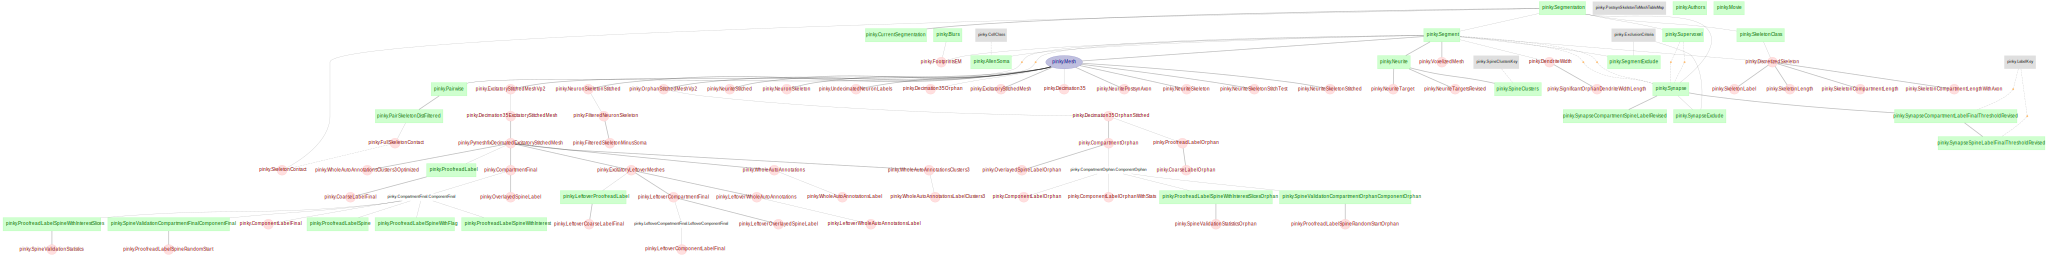

In [7]:
dj.ERD(schema)

In [8]:
# locations of all of the cell somas
pinky.AllenSoma.describe()

/usr/local/lib/python3.6/dist-packages/datajoint/connection.py:215: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


# A segment including a cell soma
-> pinky.Segment
soma_id              : int unsigned                 # soma id in Allen annotation database
---
soma_x=null          : int unsigned                 # x location of soma in grid coordinates
soma_y=null          : int unsigned                 # y location of soma in grid coordinates
soma_z=null          : int unsigned                 # z location of soma in grid coordinates
-> pinky.CellClass



'# A segment including a cell soma\n-> pinky.Segment\nsoma_id              : int unsigned                 # soma id in Allen annotation database\n---\nsoma_x=null          : int unsigned                 # x location of soma in grid coordinates\nsoma_y=null          : int unsigned                 # y location of soma in grid coordinates\nsoma_z=null          : int unsigned                 # z location of soma in grid coordinates\n-> pinky.CellClass\n'

# GET THE SIGNIFICANTLY TUNED NEURONS

In [16]:

attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
good_rf = 'mscore > 1.25'

rf_bin_edges = np.linspace(-.7, .7, 6) #setting the bin boundaries


"""
Calculate the bins and centers for the orientational preference
"""
#defines how to find the "tuned" segments of the orientation
dori_resolution = np.pi / 2 / 4 #setting the width size of the bins to be 22.5 degrees
rad2deg = 180/np.pi
bin_edges = np.linspace(0, np.pi,9) #creates 8 bins between boundaries between 0 and pi


#sets the threshold for the 
stat_choice = ["synapse_vol_density_pearson"]

ori_confidence=0.5
von_p_value=0.05

rf_bin_edges=rf_bin_edges
ori_bin_edges=bin_edges
n_seg_shared_threshold = 10
n_seg_shared_converted_threshold = 10
rf_threshold=1.45

In [17]:
# get the significantly tuned neurons: 


synapse = (pinky.Synapse - pinky.SynapseExclude) & pinky.CurrentSegmentation
segment = (pinky.Segment - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = (pinky.AllenSoma - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = soma & "cell_class='excitatory'"

"""calculate the specifics for the bins based on the bin edges given"""
###Receptive Field
#calculates the centers of the bins used for the receptive field
cbin_centers = np.hstack((np.nan, np.round((rf_bin_edges[1:] + rf_bin_edges[:-1])/2, decimals=2), np.nan))
#creates labels for the receptive field edges
cbin_labels = ['[{:.1f},{:.1f}]'.format(*a) for a in zip(rf_bin_edges[:-1], rf_bin_edges[1:])]
cbin_labels

###Orientation
rad2deg = 180/np.pi
# turns all of the bin edges into degrees with no decimal
be = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in ori_bin_edges]])
#creates the bin boundary markings with [low - high]
bin_labels = list(zip(be[:-1], be[1:]))

#calculates the bin centers
bin_centers = np.round((ori_bin_edges[1:] + ori_bin_edges[:-1])/2 * rad2deg, decimals=2)

"""
Gets the segments with the acceptable rf thresholds
"""

# functional metrics for each functional soma pair (restricting by spattune fitting significance)

sig_units_rf = spattune.BestSTA.Loc & 'sta_snr > ' + str(rf_threshold) & segment
sig_unit_pairs_rf = (sig_units_rf.proj(segment_id1 = 'segment_id') * 
                  sig_units_rf.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

print("Number of significant receptive field neurons = " + str(len(sig_units_rf)))

rf_table = (spattune.BestSTACorr.proj(rf_corr_coef="union_corr_r2",
                          segment_a="segment_id1",segment_b="segment_id2")
                          & sig_units_rf.proj(segment_a="segment_id") &
                          sig_units_rf.proj(segment_b="segment_id"))
print("Length of rf correlation = " + str(len(rf_table)))

    


Number of significant receptive field neurons = 67
Length of rf correlation = 2211


In [18]:
tuned = 'confidence > ' + str(ori_confidence)
#get the significantly tuned segments
sig_units_op = radtune.BestVonFit.Unit & 'von_p_value <= ' + str(von_p_value) & tuned & segment
print("Number of significanlty orientationally tuned neurons = " + str(len(sig_units_op)))


Number of significanlty orientationally tuned neurons = 299


In [20]:
sig_units_op

segmentation segmentation id,vonbestfit_method method index,segment_id segment id unique within each Segmentation,von_hash unique hash for combination of sta analysis methods,base von mises baseline amplitude,thetas von mises gaussian peak angle (descending amp order),amps von mises gaussian amplitudes (descending amp order),sharps von mises gaussian sharpness (descending amp order),flat_pred predictive performance of flat mean,von_pred predictive performance of von fit on unshuffled data,shuff_pred predictive performance of von fit on shuffled data,von_pred_adv von mises predictive advantage over shuffled data,von_p_value fit component p_value by reshuffle,confidence confidence value that neuron is good match
3,1,648518346341352081,43e78ae3adb467d09adcde611f01448b,0.0,=BLOB=,=BLOB=,=BLOB=,0.0311313,0.0301053,0.0306913,0.0188241,0.043,0.6998166843236705
3,1,648518346341353574,c534715cb303f36303087976793c693e,0.00190366,=BLOB=,=BLOB=,=BLOB=,0.00611624,0.00586693,0.00601307,0.0238947,0.048,0.8028348440847805
3,1,648518346341356241,66dc6420ca132a85ddda25939f084caa,0.00565237,=BLOB=,=BLOB=,=BLOB=,0.0202752,0.0178552,0.0200274,0.107137,0.001,0.957373658926309
3,1,648518346341356256,73dbecb8885beae030be3c263406f897,0.025249,=BLOB=,=BLOB=,=BLOB=,0.0679271,0.063242,0.0669904,0.0551834,0.001,1.7858262119801065
3,1,648518346341357933,3413479df9a1e7fb1b81bb8219beb975,0.0205975,=BLOB=,=BLOB=,=BLOB=,0.0512929,0.0493016,0.0505176,0.0237077,0.029,1.2074187813003094
3,1,648518346341359123,8e54b140337daf69dfda4e9fbe14ae7f,0.0297197,=BLOB=,=BLOB=,=BLOB=,0.141441,0.122979,0.139556,0.117201,0.001,3.708831526488791
3,1,648518346341361837,442a4c1f2750e405e36a35cc797f0cfb,0.00297656,=BLOB=,=BLOB=,=BLOB=,0.0218147,0.0204529,0.0214083,0.0437964,0.006,0.8310153862550999
3,1,648518346341361981,f0c077c6b3ec8074c419a09fbb23388b,0.00287949,=BLOB=,=BLOB=,=BLOB=,0.0234285,0.0217913,0.0229093,0.0477177,0.001,1.4644267171718275
3,1,648518346341362771,a7d6d9bb9c79de84f8792c46b1516c16,0.047481,=BLOB=,=BLOB=,=BLOB=,0.681801,0.587579,0.668815,0.119148,0.001,0.6869009007690088
3,1,648518346341362995,ada6b62c10a0fb25748ca0388782d537,0.0174765,=BLOB=,=BLOB=,=BLOB=,0.0364136,0.0351735,0.0358993,0.0199313,0.048,1.3336762467337846
